## Introduction

### Parameters

In [18]:
import pandas as pd
import numpy as np
import logging
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
import threading

%matplotlib inline
np.random.seed(0)
random_state = 42
print_lock = threading.Lock()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [19]:
noises = [0, 0.2, 0.4, 0.6, 0.8]

n_estimators = [15, 30, 50, 75, 100, 150, 200, 300, 350, 400]
max_depth = [None, 5, 10]
min_samples_split = [2, 5, 10]
learning_rate = [0.01, 0.1, 1]

stratified_k_fold = StratifiedKFold(n_splits=2, shuffle=True, random_state=random_state)
variance_threshold = VarianceThreshold()

model_name_map = { 'rf': 'Random Forest', 'gb': 'Gradient Boosting' }

rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
gb = GradientBoostingClassifier(random_state=random_state)
dummy = DummyClassifier(strategy='most_frequent')

selector = SelectFromModel(rf, threshold='mean')

### Datasets splits and exploratory analysis

In [20]:
# read cancer data
X_cancer = pd.read_csv('../data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y_cancer = pd.read_csv('../data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

Y_cancer['x'].unique()
# assign a numbered label for Y
label_map_cancer = {'GBM': 0, 'BC': 1, 'OV': 2, 'LU': 3, 'KI': 4, 'U': 5}
Y_cancer['x'] = Y_cancer['x'].map(label_map_cancer)

/tmp/ipykernel_8195/2658123069.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_cancer = pd.read_csv('../data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)


/tmp/ipykernel_8195/2658123069.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Y_cancer = pd.read_csv('../data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)


In [21]:
# read cats and dogs data
X_cats_dogs = pd.read_csv('../data/CATSnDOGS.csv')
Y_cats_dogs = pd.read_csv('../data/CATSnDOGSlabels.csv')

In [22]:
def splits(X, Y, gaussian_noise_factor=0, test_size=0.2):
    ''' Split into train and test. Includes noise and mislabeling. '''
    noise = np.random.normal(0, 1, X.shape)
    X = X + gaussian_noise_factor * noise
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
    return X_train, X_test, Y_train, Y_test

In [23]:
X_cats_dogs.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4087,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096
0,23,116,227,149,49,131,31,31,86,86,...,59,116,102,78,102,102,116,139,152,166
1,247,247,245,245,245,245,245,235,235,223,...,110,100,100,70,66,70,70,70,70,78
2,77,77,77,87,87,94,94,94,105,87,...,116,125,128,128,128,128,125,125,116,116
3,32,28,28,28,28,28,28,28,28,28,...,73,73,73,79,108,131,148,148,148,131
4,3,44,112,136,120,120,125,122,129,133,...,186,184,181,180,179,173,170,192,119,14


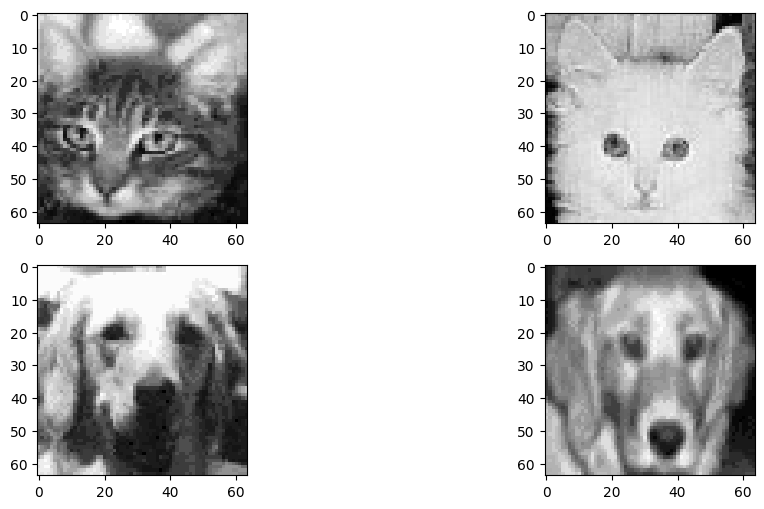

In [24]:
def rotateM(x):
    return np.transpose(np.apply_along_axis(np.flip, 0, x))

def plot_images(indices, data, category, cmap='gray'):
    for idx, i in enumerate(indices):
        plt.subplot(2, 2, idx + 1 + category * 2)
        plt.imshow(rotateM(data.iloc[i, :].values.reshape(64, 64)), cmap=cmap)
        plt.xlabel('')
        plt.ylabel('')

# random selections
ssc = np.random.choice(np.where(Y_cats_dogs == 0)[0], 2, replace=False)
ssd = np.random.choice(np.where(Y_cats_dogs == 1)[0], 2, replace=False)

plt.figure(figsize=(12, 6))
plot_images(ssc, X_cats_dogs, category=0)
plot_images(ssd, X_cats_dogs, category=1)
plt.show()

## Setup

### Pipeline and grid search

In [25]:
# Parameter grid for Random Forest (bagging)
params_rf = {
    'classifier__n_estimators': n_estimators,
    # 'classifier__max_depth': max_depth,
    # 'classifier__min_samples_split': min_samples_split,
    # 'classifier__max_features': ['sqrt', 'log2'],
}

# Parameter grid for Gradient Boosting
params_gb = {
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    'classifier__min_samples_split': min_samples_split,
    'classifier__learning_rate': learning_rate,
    
    # TO DO: see if the paramters below are useful
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [0, 0.1, 0.5]
}

pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    #('feature_selection', selector),
    ('classifier', rf),
])

def grid_search(X_train, Y_train, model: str):
    if model == 'rf':
        #pipeline.named_steps['feature_selection'].estimator_ = rf
        pipeline.named_steps['classifier'] = rf
        params = params_rf
    elif model == 'gb':
        #pipeline.named_steps['feature_selection'].estimator_ = gb
        pipeline.named_steps['classifier'] = gb
        params = params_gb
    else:
        raise ValueError('Invalid model name')
    
    grid_search_res = GridSearchCV(pipeline, params, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search_res.fit(X_train, np.ravel(Y_train))
        
    return grid_search_res

### Plots and displays

In [26]:
def plot_learning_trend(grid_search_res, model_name, noise):
    results = grid_search_res.cv_results_
    
    # mean test scores for each estimator with the same value of n_estimators
    mean_scores = []
    for n in n_estimators:
        mask = results['param_classifier__n_estimators'] == n
        if np.any(mask):
            mean_scores.append(np.mean(results['mean_test_score'][mask]))
        else:
            mean_scores.append(np.nan)
    
    plt.figure(figsize=(8, 6))
    plt.plot(n_estimators, mean_scores, marker='o')
    plt.xlabel('n estimators')
    plt.ylabel('cv score')
    plt.title(f'Learning trend for different n_estimators ({model_name_map[model_name]}, {noise * 100}% noise)')
    plt.grid(True)
    plt.savefig(f"imgs/{model_name}_plot_n_estimators_noise_{noise}.png")
    plt.show()
    
def plot_confusion_matrix(Y_test, Y_test_pred, labels, model_name, noise):
  # confusion matrix and display
  cm = confusion_matrix(Y_test, Y_test_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  # plot the confusion matrix
  cm_display.plot()
  plt.title(f'Confusion matrix ({model_name_map[model_name]}, {noise * 100}% noise)')
  plt.savefig(f"imgs/{model_name}_confusion_matrix_noise_{noise}.png")
  plt.show()
  
def show_classification_report(X_test, Y_test, grid_search_res, model_name: str, noise):
  Y_test_pred = grid_search_res.predict(X_test)
  best_params = grid_search_res.best_params_
  print(f"Classification Report \nOptimal parameters {best_params} ({model_name_map[model_name]}, noise: {noise * 100}%)\n",
      classification_report(Y_test, Y_test_pred)) 

def show_feature_importance(grid_search_res, X, model_name: str, noise: float):
    # feature importances from the best estimator
    best_estimator = grid_search_res.best_estimator_.named_steps['classifier']
    feature_importances = best_estimator.feature_importances_
    # feature names for features kept after filtering
    variance_threshold = grid_search_res.best_estimator_.named_steps['variance_threshold']
    feature_names = X.columns[variance_threshold.get_support()]
    print(f'Length of feature_names: {len(feature_names)}')
    print(f'Length of feature_importances: {len(feature_importances)}')

    # dataframe for feature importances
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    top_10_features = feature_importance_df.sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(8, 6))
    plt.bar(top_10_features['feature'], top_10_features['importance'], color='steelblue')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f'Top 10 Features ({model_name}, {noise * 100:.1f}% Noise)')
    plt.xticks(rotation=45, ha='right')
    plt.savefig(f"imgs/{model_name}_top_10_features_noise_{noise}.png", bbox_inches='tight')
    plt.show()

### Main processes

In [27]:
def process_noise(model_name, noise):
    # split dataset
    X_train, X_test, Y_train, Y_test = splits(X_cancer, Y_cancer, noise)
    
    # grid search and metrics
    grid_search_res = grid_search(X_train, Y_train, 'rf')
    balanced_ac_score = balanced_accuracy_score(Y_test, grid_search_res.predict(X_test))
    f1_scores = f1_score(Y_test, grid_search_res.predict(X_test), average='weighted')
    
    # show results
    with print_lock:
        plot_learning_trend(grid_search_res, model_name, noise)
        show_classification_report(X_test, Y_test, grid_search_res, model_name, noise)
        plot_confusion_matrix(Y_test, grid_search_res.predict(X_test), Y_cancer['x'].unique(), model_name, noise)
        show_feature_importance(grid_search_res, X_train, model_name, noise)
    
    return {'noise': noise, 'grid_search_res': grid_search_res, 'balanced_ac_score': balanced_ac_score, 'f1_score': f1_scores}

In [28]:
def main(model_name: str):
    logging.info(f'Starting main function with model_name: {model_name}')
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for noise in noises:
            logging.info(f'Submitting task for noise level: {noise}')
            future = executor.submit(process_noise, model_name, noise)
            futures.append(future)
        
        results = []
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            result = future.result()
            results.append(result)
            logging.info(f'Task {i + 1} completed with result: {result}')
    
    logging.info('All tasks completed.')

In [29]:
def main_seq(model_name: str):
  reuslts = []
  for noise in noises:
    logging.info(f'Submitting task for noise level: {noise}')
    
    futures.append(future)

SyntaxError: incomplete input (1950268473.py, line 2)

## Test

2024-04-25 11:23:52,214 - INFO - Starting main function with model_name: rf
2024-04-25 11:23:52,215 - INFO - Submitting task for noise level: 0
2024-04-25 11:23:52,216 - INFO - Submitting task for noise level: 0.2
2024-04-25 11:23:52,217 - INFO - Submitting task for noise level: 0.4
2024-04-25 11:23:52,218 - INFO - Submitting task for noise level: 0.6
2024-04-25 11:23:52,218 - INFO - Submitting task for noise level: 0.8


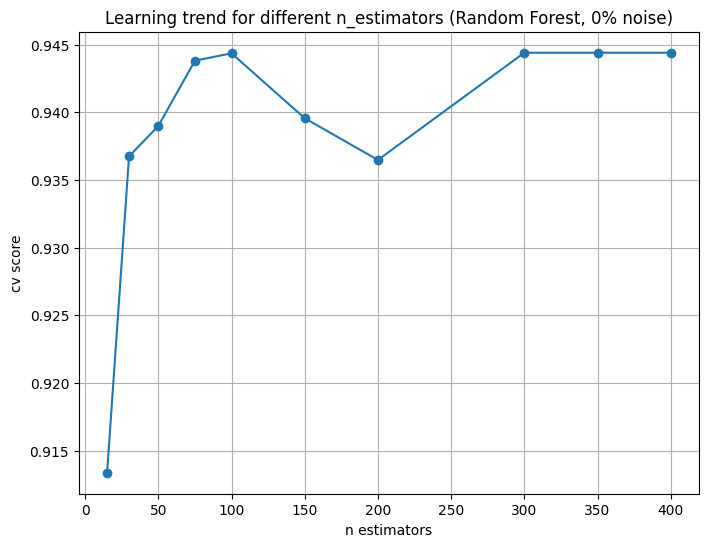

Classification Report 
Optimal parameters {'classifier__n_estimators': 300} (Random Forest, noise: 0%)
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.98      1.00      0.99       243
           2       1.00      1.00      1.00        53
           3       1.00      0.99      1.00       114
           4       1.00      0.99      1.00       121
           5       1.00      0.75      0.86        12

    accuracy                           0.99       578
   macro avg       1.00      0.96      0.97       578
weighted avg       0.99      0.99      0.99       578



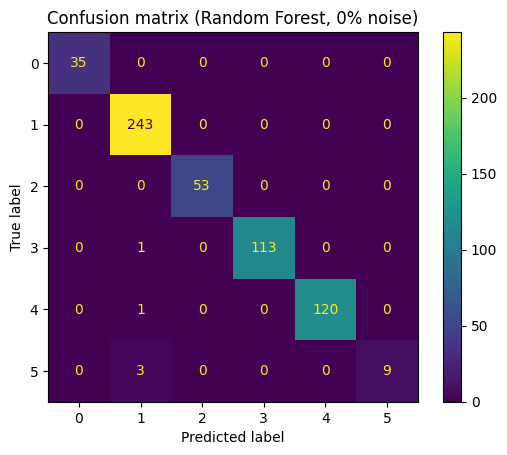

Length of feature_names: 1983
Length of feature_importances: 1983


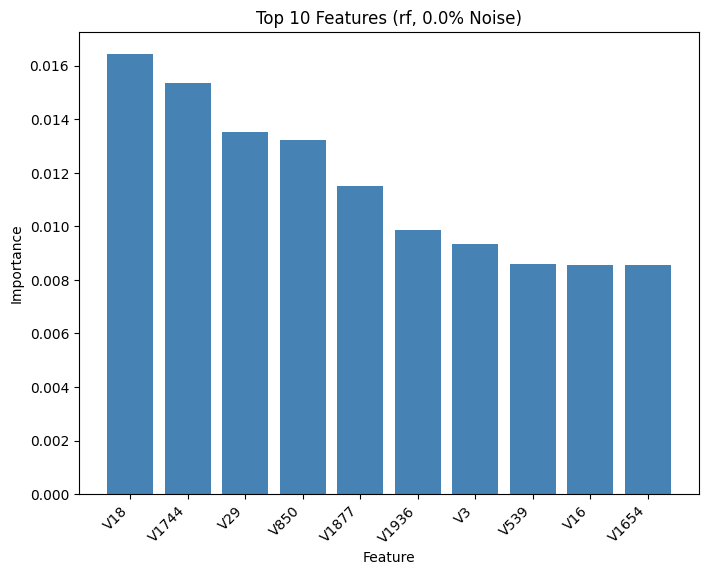

2024-04-25 11:24:55,720 - INFO - Task 1 completed with result: {'noise': 0, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [15, 30, 50, 75, 100, 150,
                                                      200, 300, 350, 400]},
             scoring='balanced_accuracy'), 'balanced_ac_score': 0.9554939345609202, 'f1_score': 0.9910153896232151}


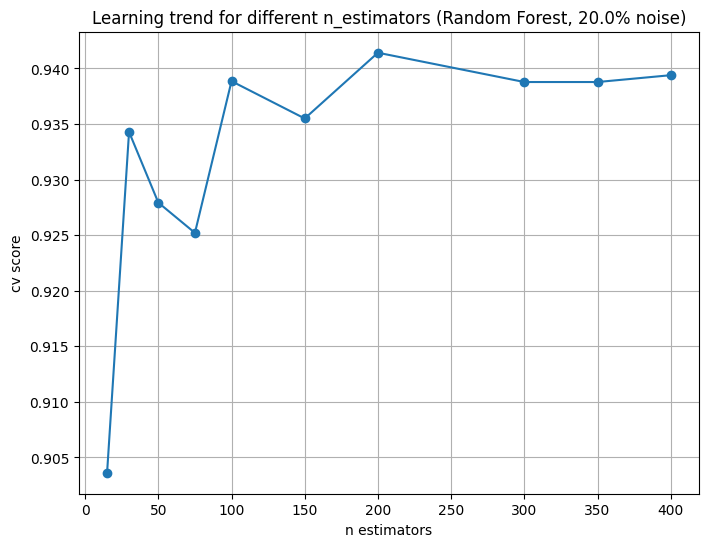

Classification Report 
Optimal parameters {'classifier__n_estimators': 200} (Random Forest, noise: 20.0%)
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.98      1.00      0.99       243
           2       1.00      1.00      1.00        53
           3       1.00      0.98      0.99       114
           4       1.00      0.99      1.00       121
           5       1.00      0.83      0.91        12

    accuracy                           0.99       578
   macro avg       1.00      0.97      0.98       578
weighted avg       0.99      0.99      0.99       578



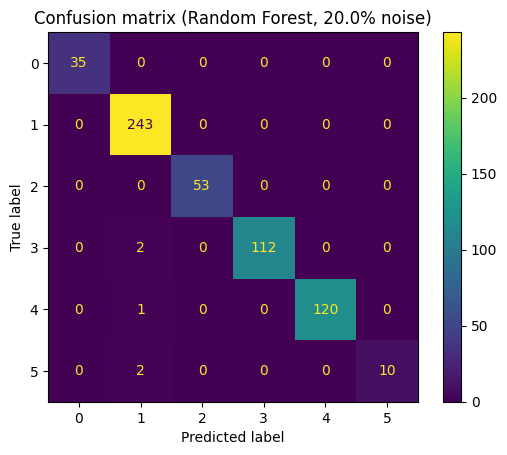

Length of feature_names: 2000
Length of feature_importances: 2000


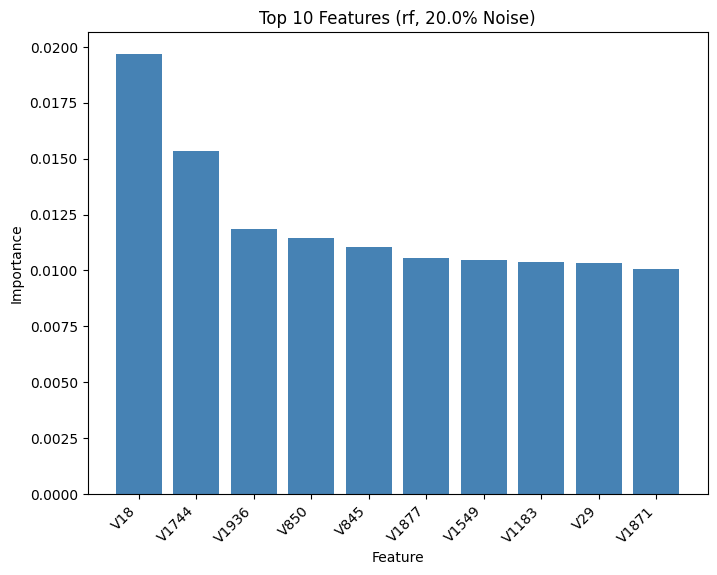

2024-04-25 11:25:02,592 - INFO - Task 2 completed with result: {'noise': 0.2, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [15, 30, 50, 75, 100, 150,
                                                      200, 300, 350, 400]},
             scoring='balanced_accuracy'), 'balanced_ac_score': 0.9679208351457155, 'f1_score': 0.9912173441371014}


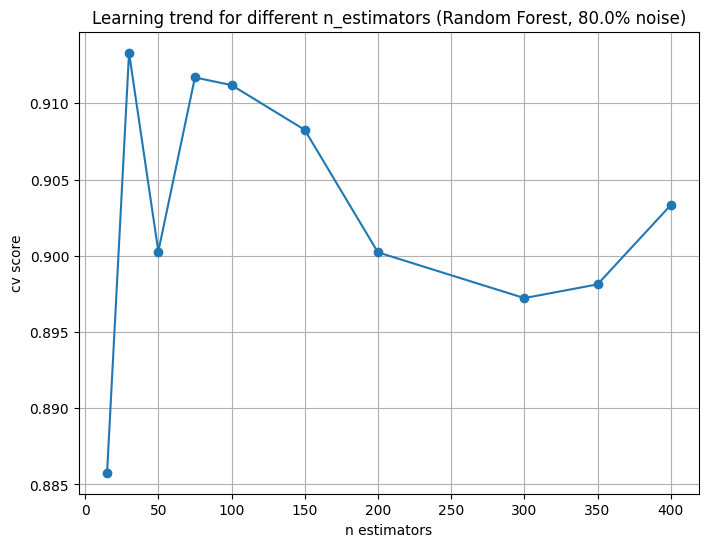

Classification Report 
Optimal parameters {'classifier__n_estimators': 30} (Random Forest, noise: 80.0%)
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.96      1.00      0.98       243
           2       1.00      1.00      1.00        53
           3       1.00      0.98      0.99       114
           4       1.00      0.99      1.00       121
           5       1.00      0.50      0.67        12

    accuracy                           0.98       578
   macro avg       0.99      0.91      0.94       578
weighted avg       0.98      0.98      0.98       578



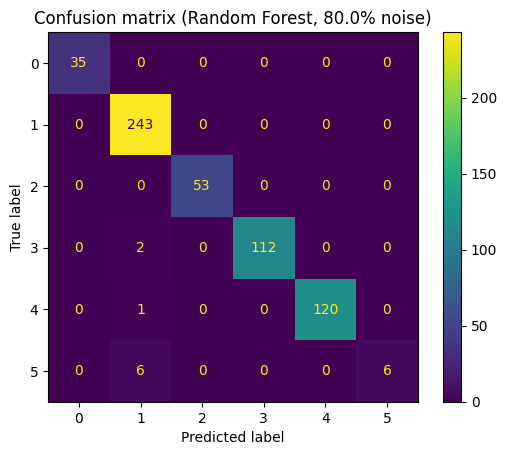

Length of feature_names: 2000
Length of feature_importances: 2000


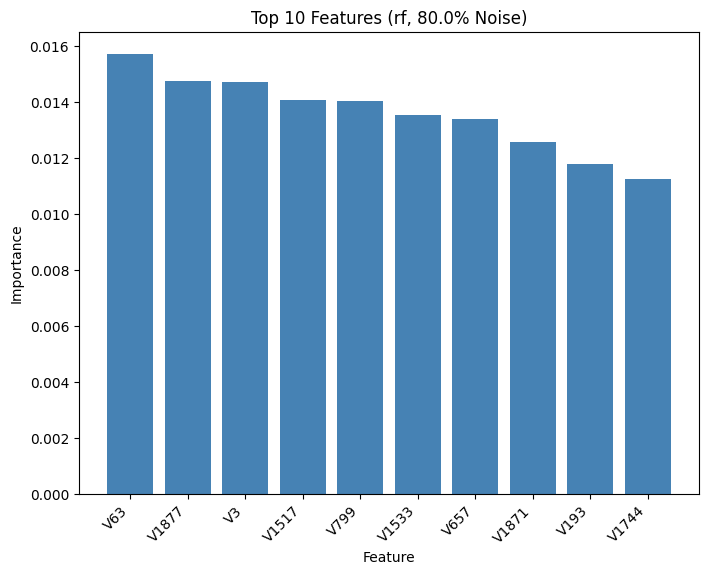

2024-04-25 11:25:04,994 - INFO - Task 3 completed with result: {'noise': 0.8, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [15, 30, 50, 75, 100, 150,
                                                      200, 300, 350, 400]},
             scoring='balanced_accuracy'), 'balanced_ac_score': 0.9123652795901599, 'f1_score': 0.9828216158053622}


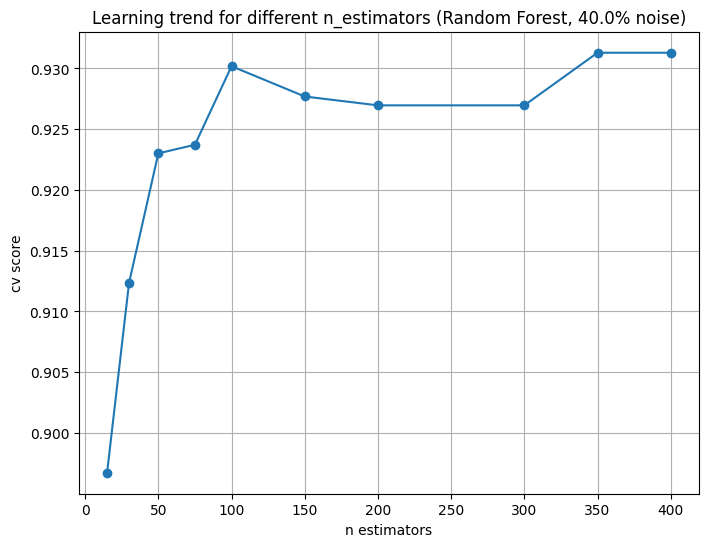

Classification Report 
Optimal parameters {'classifier__n_estimators': 350} (Random Forest, noise: 40.0%)
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.98      1.00      0.99       243
           2       1.00      1.00      1.00        53
           3       1.00      0.99      1.00       114
           4       1.00      0.99      1.00       121
           5       1.00      0.75      0.86        12

    accuracy                           0.99       578
   macro avg       1.00      0.96      0.97       578
weighted avg       0.99      0.99      0.99       578



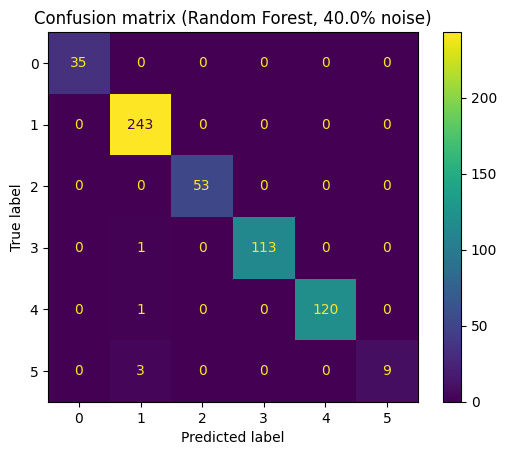

Length of feature_names: 2000
Length of feature_importances: 2000


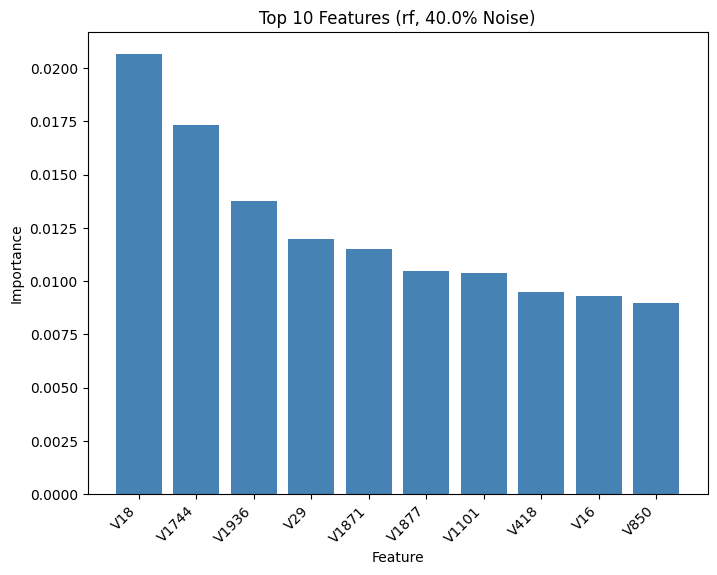

2024-04-25 11:25:18,166 - INFO - Task 4 completed with result: {'noise': 0.4, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [15, 30, 50, 75, 100, 150,
                                                      200, 300, 350, 400]},
             scoring='balanced_accuracy'), 'balanced_ac_score': 0.9554939345609202, 'f1_score': 0.9910153896232151}


Classification Report 
Optimal parameters {'classifier__n_estimators': 150} (Random Forest, noise: 60.0%)
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.98      1.00      0.99       243
           2       1.00      1.00      1.00        53
           3       1.00      0.99      1.00       114
           4       1.00      0.99      1.00       121
           5       1.00      0.75      0.86        12

    accuracy                           0.99       578
   macro avg       1.00      0.96      0.97       578
weighted avg       0.99      0.99      0.99       578



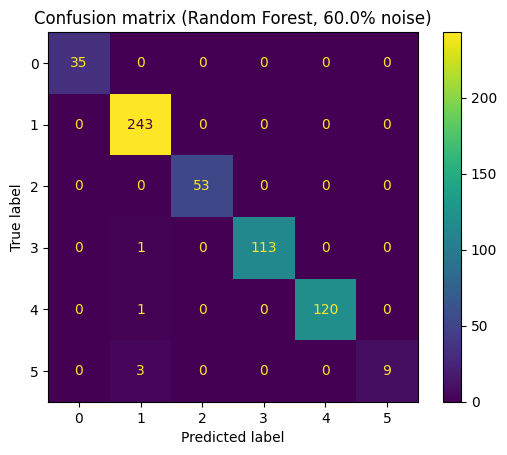

Length of feature_names: 2000
Length of feature_importances: 2000


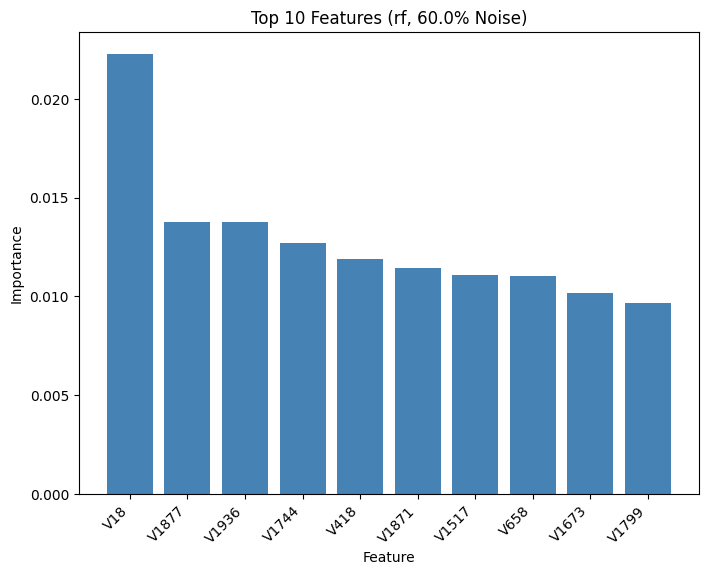

2024-04-25 11:25:18,631 - INFO - Task 5 completed with result: {'noise': 0.6, 'grid_search_res': GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__n_estimators': [15, 30, 50, 75, 100, 150,
                                                      200, 300, 350, 400]},
             scoring='balanced_accuracy'), 'balanced_ac_score': 0.9554939345609202, 'f1_score': 0.9910153896232151}
2024-04-25 11:25:18,632 - INFO - All tasks completed.


In [ ]:
# process_noise('rf', 0)
main('rf')

In [ ]:
#main('gb')